# Fitting WA Parameters as one big population

After SA's parameters failed, wanted to see if we could fit WA's outbreak using the same methods.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [3]:
waloc = pd.read_csv('/Users/Yuval/Desktop/Thesis/all-wa-pos.csv')#use this for all 297 towns
waloc = waloc.loc[waloc['Population'] >0]
# When doing big towns
waloc = waloc[:58]

# When ignoring sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Yanchep') & (waloc['City / Town'] != 'Bullsbrook') &
                  (waloc['City / Town'] != 'Mundijong') & (waloc['City / Town'] != 'Serpentine') &
                 (waloc['City / Town'] != 'Two Rocks') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring rural satellites
waloc = waloc.loc[(waloc['City / Town'] != 'Pinjarra') & (waloc['City / Town'] != 'Drummond Cove') &
                  (waloc['City / Town'] != 'Bridgetown') & (waloc['City / Town'] != 'Binningup') &
                 (waloc['City / Town'] != 'Dampier') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring 0 flow towns
waloc = waloc.loc[(waloc['City / Town'] != 'Kununurra') & (waloc['City / Town'] != 'Derby') &
                  (waloc['City / Town'] != 'Boddington-Ranford') & (waloc['City / Town'] != 'Wyndham')]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

In [4]:
# WA Data Processing
wa_data = pd.read_csv('/Users/Yuval/Desktop/Thesis/wa_health.csv')

# Daily cases
wa_totals = list(wa_data.iloc[0])[1:]
wa_totals = [i - 1134 for i in wa_totals]
wa_infs = [0]
for i in range(1,len(wa_totals)):
    wa_infs.append(wa_totals[i]-wa_totals[i-1])
    
total_popn = sum(list(waloc['Population']))

# WA's population is 2491996 people over 5
# https://www.health.gov.au/sites/default/files/documents/2022/02/covid-19-vaccine-rollout-update-1-february-2022.pdf
# There are 377018 people between 5-15, so normalise the third dose based on that

first = list(wa_data.loc[wa_data['Source'] == 'COVID-live First Doses 5+'].iloc[0])[1:]
first = [round(i/2491996*total_popn) for i in first]
first_change = []
for f in range(len(first)-1):
    first_change.append(first[f+1] - first[f])

second = list(wa_data.loc[wa_data['Source'] == 'COVID-live Second Doses 5+'].iloc[0])[1:]
second = [round(i/2491996*total_popn) for i in second]
second_change = []
for f in range(len(second)-1):
    second_change.append(second[f+1] - second[f])

third = list(wa_data.loc[wa_data['Source'] == 'COVID-live Booster Doses 16+'].iloc[0])[1:]
third = [round(i*2491996/(2491996-377018)) for i in third]
third = [round(i/2491996*total_popn) for i in third]
third_change = []
for f in range(len(third)-1):
    third_change.append(third[f+1] - third[f])

uptakes = [first_change, second_change, third_change]

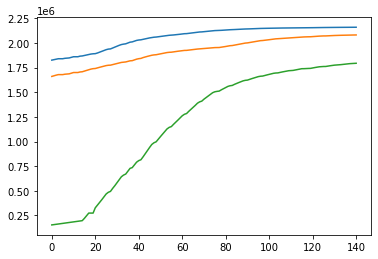

In [5]:
plt.plot(first)
plt.plot(second)
plt.plot(third)

In [6]:
# Make sure there are no negatives
for i in range(len(uptakes)):
    for j in range(len(uptakes[i])):
        if uptakes[i][j] < 0:
            print(i,j)
            uptakes[i][j] = 0

In [7]:
# Find initial values

init_first_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live First Doses 5+'].iloc[0])[1]
init_first_dose = init_first_dose/2491996
init_second_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live Second Doses 5+'].iloc[0])[1]
init_second_dose = init_second_dose/2491996
init_third_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live Booster Doses 16+'].iloc[0])[1]
init_third_dose = init_third_dose*2491996/(2491996-377018)
init_third_dose = init_third_dose/2491996

init1 = init_first_dose- init_second_dose
init2 = init_second_dose - init_third_dose
init3 = init_third_dose

In [8]:
# Five point moving average (for finding inflections)
def moving_average(llist, w_size):
    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []
    
    #for j in range(int((w_size - 1)/2)):
    #    window_average = np.sum(llist[:j+1])/(j+1)
    #    moving_averages.append(window_average)
        
    while i < len(llist) - w_size + 1:
        window_average = np.sum(llist[i:i+w_size]) / w_size
        moving_averages.append(window_average)
        i += 1
    
    #for j in [3,2,1,0]:
    #    window_average = np.sum(llist[len(llist)-j-1:])/(j+1)
    #    moving_averages.append(window_average)

    return moving_averages

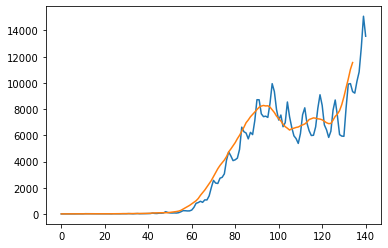

In [9]:
ma = moving_average(wa_infs,7)
plt.plot(wa_infs)
plt.plot(ma)

In [10]:
from scipy.optimize import curve_fit

In [11]:
def sveir(params,x,popn,changes, effic):
    xdot = list(np.zeros(7))
    eff1, eff2, eff3 = effic[0], effic[1], effic[2]
    xdot[0] = -params[0]*x[0]*x[5]/popn - changes[0] # Susceptible
    xdot[1] = -eff1*params[0]*x[1]*x[5]/popn +changes[0] - changes[1]  # First dose
    xdot[2] = -eff2*params[0]*x[2]*x[5]/popn + changes[1] - changes[2] # Second dose
    xdot[3] = -eff3*params[0]*x[3]*x[5]/popn + changes[2] + 1/84*x[6]  # Third dose
    xdot[4] = params[0]*x[0]*x[5]/popn + eff1*params[0]*x[1]*x[5]/popn + eff2*params[0]*x[2]*x[5]/popn + eff3*params[0]*x[3]*x[5]/popn - params[1]*x[4] # Exposed
    xdot[5] = params[1]*x[4] - params[2]*x[5] # Infected
    xdot[6] = params[2]*x[5] - 1/84*x[6] # Removed
    
    infected_daily = params[1]*x[4]
    return xdot, infected_daily

In [12]:
total_popn

2290651

In [13]:
# The big one
def dynamics(x_init,days,steps,a1,a2,a3,a4,a5,uptakes, effic, L, D,inflection_points):
    x = [x_init]
    day_infs = [0]
    
    params = [a1, 1/L, 1/D]
    
    inf_1, inf_2, inf_3, inf_4 = inflection_points[0],inflection_points[1],inflection_points[2],inflection_points[3]
    
    # Iterate over each day
    popul = []
    for day in range(days):
        #Step 1: try the different alphas
            
        if day < inf_1:
            params[0] = a1
        elif (day>= inf_1) and (day < inf_2):
            params[0] = a2
        elif (day >=inf_2) and (day<inf_3):
            params[0] = a3
        elif (day>=inf_3) and (day<inf_4):
            params[0] = a4
        elif day>inf_4:
            params[0] = a5
            
            
#         if day < inf_1:
#             params[0] = a1
#         elif (day>= inf_1) and (day < inf_2):
#             params[0] = a2
#         elif (day >=inf_2) and (day<inf_3):
#             params[0] = a3
#         elif (day>=inf_3):
#             params[0] = a4

# SA comparison
#         if day < 27:
#             params[0] = a1
#         elif (day >= 27) and (day < 70):
#             params[0] = a2
#         elif (day >= 70):
#             params[0] = a3
            
        #print(day,params)
        if day < 140:    
            changes = [uptakes[0][day],uptakes[1][day], uptakes[2][day]]
        else:
            changes = [0,0,0]
        
        # print(day)
        # Step 2: Use the SEIR equation to simulate the spread over the day.
        infected_daily =[]
        for t in range(steps):
            xdot, infs = sveir(params, x[-1], popn,changes,effic)
            xdot = [i/steps for i in xdot]
            x.append([sum(i) for i in zip(*[x[-1],xdot])])
            popul.append(sum(x[-1]))
            infected_daily.append(infs)
        day_infs.append(sum(infected_daily)/steps+day_infs[-1])
        #print(infected_daily, day_infs[-1])
        
    return x, day_infs, popul

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


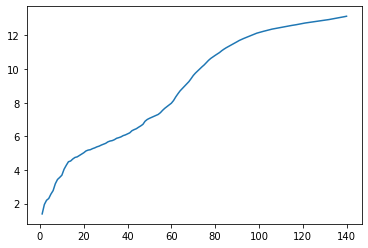

In [14]:
plt.plot(np.log(wa_totals))

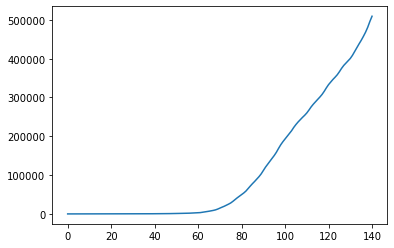

In [15]:
plt.plot(wa_totals)

In [16]:
def plotting(y):
    s = list(zip(*y))
    plt.figure(figsize = (6,6))
    plt.plot(s[0],'k', label ='Susceptible')
    plt.plot(s[1],label = 'V1')
    plt.plot(s[2],label = 'V2')
    plt.plot(s[3], label = 'V3')
    plt.plot(s[4],'b', label = 'Exposed')
    plt.plot(s[5],'r', label = 'Infected')
    plt.plot(s[6],'y', label = 'Recovered')
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Number of infected")
    plt.xlim([0,steps*days])
    plt.tight_layout()

In [23]:
effic = [1-0.293, 1-0.126, 1-0.566]
# Set the initial town values (when doing final simulations make sure this is accurate)
popn = 2290651
one = 1/popn
x_init = [1-init1 - init2 - init3 - 5*one, init1 - 5*one, init2 - 5*one, init3 - 5*one, 16*one, 4*one,0]
x_init = [x*popn for x in x_init]

# Set number of days for this simulation
days = 140

# SA
#inflection_points = [27,70,1000,1000] 


# inflection_points = [21,49,76,101]
# inflection_points = [9,59,80,115]
# inflection_points = [50,90,112,1000]
# inflection_points = [17, 45, 79, 1000]
# inflection_points = [16, 46, 77, 108]

# THIS ONE
inflection_points = [16, 44, 80, 1000]

L = 2.43
D = 3.778

# If fitting overall cases
#a1, a2,a3,a4 = 0.4237464 , 0.92249785, 0.6465886 , 0.48335045
# a1, a2,a3,a4,a5 = 0.42612819, 0.49659472, 0.96843909, 0.59028204, 0.54730821
# a1, a2,a3,a4,a5 = 0.23728126, 0.57585951, 1.00389018, 0.53762977, 0.64000607
# a1, a2,a3,a4,a5 = 0.52428121, 0.76622621, 0.49006648, 0.64172917,1
# a1, a2,a3,a4,a5 = 0.43297407, 0.45641545, 0.91154094, 0.56411763, 1
#a1, a2,a3,a4,a5 =0.43041339, 0.46107978, 0.93485555, 0.58096885, 0.54704221
#a1, a2,a3,a4,a5 =0.42812041, 0.46897381, 0.91151792, 0.55597001, 1

# THIS ONE
a1, a2,a3,a4,a5 =0.43515505, 0.44825408, 0.8968397 , 0.55971941,1

#Adelaide params
#a1, a2,a3, a4 = 0.95474459, 0.29760718, 0.53051565, 3.7781223

# If fitting daily cases
#a1, a2,a3, D = 2.21435632, 1.27734592, 1.92716264, 1.

#SA parameters
#a1,a2,a3,a4, a5 = 0.96798581, 0.30065131, 0.54189703,1,1

params = [a1, 1/L, 1/D]

steps = 5

# Call the function (just once)
y, day_infs, popul = dynamics(x_init,days,steps,a1,a2,a3,a4,a5,uptakes,effic, L, D,inflection_points)

In [24]:
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


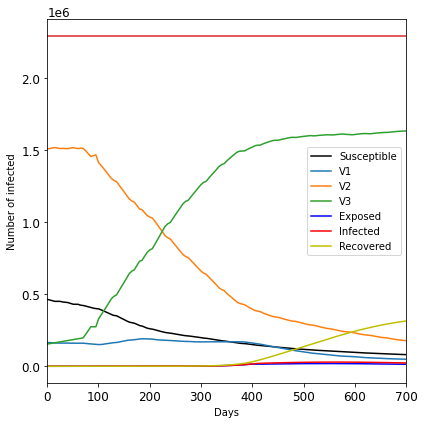

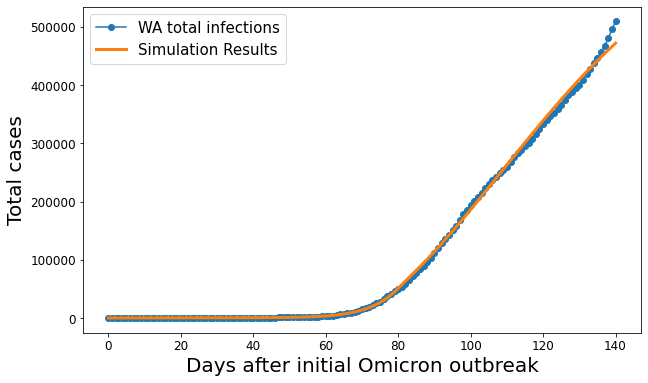

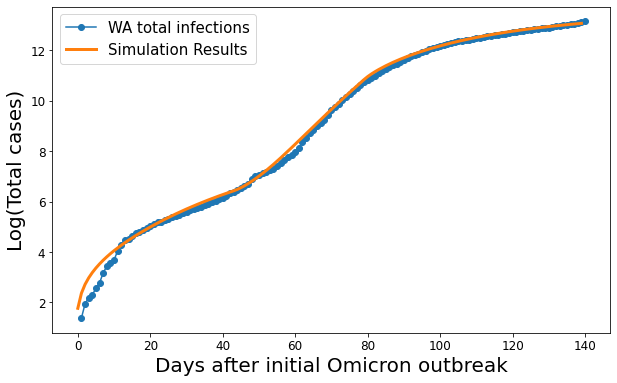

In [25]:
plotting(y)
plt.plot(popul)
plt.figure(figsize = (10,6))
#x = [i/5 for i in range(5*105)]
#plt.plot(x,datt)
plt.plot(wa_totals, label = 'WA total infections', marker = 'o')
plt.plot(day_infs, label = 'Simulation Results',linewidth = 3)
plt.ylabel('Total cases', size = 20)
plt.xlabel('Days after initial Omicron outbreak', size = 20)
plt.legend(fontsize = 15)
#plt.title('Using Adelaide\'s outbreak to of best fit parameters', size =20)
plt.figure(figsize = (10,6))
#x = [i/5 for i in range(5*105)]
#plt.plot(x,datt)
plt.plot(list(np.log(wa_totals)), label = 'WA total infections', marker = 'o')
plt.plot(list(np.log(day_infs))[1:], label = 'Simulation Results', linewidth = 3)
plt.ylabel('Log(Total cases)', size = 20)
plt.xlabel('Days after initial Omicron outbreak', size = 20)
plt.legend(fontsize = 15)
#plt.title('Using Adelaide\'s outbreak to of best fit parameters', size =20)

In [26]:
daily_infs = [0]
for i in range(1,len(day_infs)):
    daily_infs.append(day_infs[i]- day_infs[i-1])

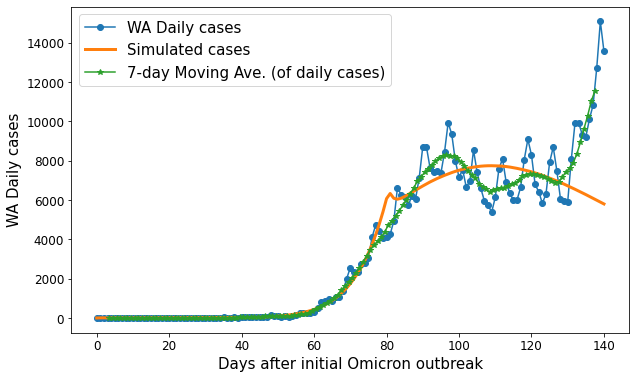

In [29]:
plt.figure(figsize = (10,6))
plt.plot(wa_infs, marker = 'o', label = 'WA Daily cases')
plt.plot(daily_infs, label = 'Simulated cases',linewidth = 3)
plt.plot([i+3.5 for i in range(135)],ma, marker = '*', label = '7-day Moving Ave. (of daily cases)')
plt.xlabel('Days after initial Omicron outbreak', size = 15)
plt.ylabel('WA Daily cases', size = 15)
plt.legend(fontsize = 15)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


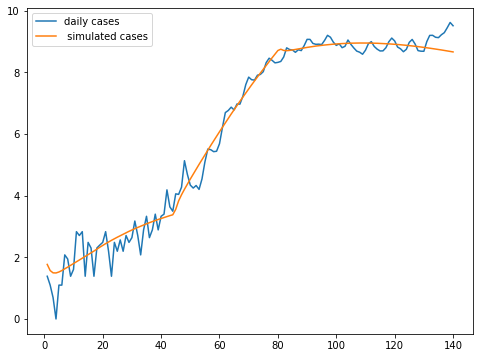

In [35]:
plt.figure(figsize = (8,6))
#plt.plot(ma, label = '7 day moving average')
plt.plot(np.log(wa_infs), label = 'daily cases')
plt.plot(np.log(daily_infs), label = ' simulated cases')
plt.legend()

## Fitting using log

In [22]:
a5 = 1
inflection_points = [16,44,80,1000]

In [23]:
def func(x, a1, a2, a3,a4):
    y, day_infs, popul = dynamics(x_init,days,steps,a1,a2,a3,a4,a5,uptakes,effic, L, D,inflection_points)
    return list(np.log(day_infs))[1:] # if fitting log cases
    # If fitting daily cases
    #daily_infs = [0]
    #for i in range(1,len(day_infs)):
    #    daily_infs.append(day_infs[i]- day_infs[i-1])
    #return list(daily_infs)[:]
    #return list(day_infs)[1:]

In [24]:
x = [i for i in range(1,len(wa_totals))]
y = list(np.log(wa_totals))[1:]
#y = list(wa_totals)[1:]
#y = ma # if fitting daily cases

popt, pcov = curve_fit(func, x, y,bounds = (0.1,3))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
popt

array([0.43515505, 0.44825408, 0.8968397 , 0.55971941])

In [26]:
allDone()
# Three inflection points is best at 16, 44, 80.

In [27]:
popt

array([0.43515505, 0.44825408, 0.8968397 , 0.55971941])

In [28]:
perr = np.sqrt(np.diag(pcov))
perr *=2
perr

array([0.01338116, 0.01403918, 0.0152726 , 0.01358285])

In [29]:
# 95% CI
parnames = ['del_1','del_2', 'del_3', 'del_4']
print("{:5s}  {:5s}  {:5s}  {:5s}".format('Par','Val','LB','UB'))
for i in range(4):
    print("{:5s}  {:.3f}  {:.3f}  {:.3f}".format(parnames[i], round(popt[i],3), round(popt[i]-perr[i],3), 
                                           round(popt[i] +perr[i],3)))

Par    Val    LB     UB   
del_1  0.435  0.422  0.449
del_2  0.448  0.434  0.462
del_3  0.897  0.882  0.912
del_4  0.560  0.546  0.573


In [36]:
# Find R_0
dels = [.43515505, 0.44825408, 0.8968397 , 0.55971941]
inf_pts = [0,16,44,80,1000]

for j in range(4):
    i = inf_pts[j]
    de = dels[j]
    cu = y[i*steps]
    smc = sum(cu)
    eff_delta = cu[0]/smc*de + effic[0]*cu[1]/smc*de + effic[1]*cu[2]/smc*de + effic[2]*cu[3]/smc*de
    R0 = eff_delta * sum(cu[0:4])/smc / (1/D)
    print(i,R0)

0 1.410425675033952
16 1.4188143515890763
44 2.3688229899621023
80 1.1393563773319784


## Fitting Inflection Points

In [30]:
inf_1s = [5+i for i in range(20)]
inf_2s = [40+i for i in range(20)]
inf_3s = [75+i for i in range(25)]
inf_4s = [1000]
bestguess = [15,45,85,1000]
newguess = [15,45,85,1000]

allgoods = []
x = [i for i in range(1,len(wa_totals))]
y = np.log(list(wa_totals))[1:]
new_infs = [inf_1s,inf_2s,inf_3s,inf_4s]


stop = 'no'
while stop == 'no':
    bestguess = newguess[:]
    all_infs = new_infs
    newguess = [0,0,0,0]
    print(bestguess)
    for k in range(3):
        goodness = []
        for item in all_infs[k]:
            #print(bestguess)

            inflection_points = bestguess[:]
            inflection_points[k] = item
            try:
                popt, pcov = curve_fit(func, x, y,bounds = (0.1,3))
                goodness.append(sum(np.sqrt(np.diag(pcov))))
            except:
                goodness.append(1000)

            #print(item)
        allgoods.append(goodness)
        
        inf_pt = all_infs[k][0]+ goodness.index(min(goodness))
        newguess[k] = inf_pt
        #new_infs[k] = [max(inf_pt - 10,1) + i for i in range(20)]

        print('Best guess for inflection ' + str(k+1) + ' is ' + str(inf_pt))
    newguess[3] = 1000
    print(bestguess,newguess)
    if bestguess == newguess:
        stop = 'yes'
    else:
        stop = 'no'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


[15, 45, 85, 1000]
Best guess for inflection 1 is 18
Best guess for inflection 2 is 42
Best guess for inflection 3 is 79
[15, 45, 85, 1000] [18, 42, 79, 1000]
[18, 42, 79, 1000]
Best guess for inflection 1 is 16
Best guess for inflection 2 is 44
Best guess for inflection 3 is 80
[18, 42, 79, 1000] [16, 44, 80, 1000]
[16, 44, 80, 1000]
Best guess for inflection 1 is 16
Best guess for inflection 2 is 44
Best guess for inflection 3 is 80
[16, 44, 80, 1000] [16, 44, 80, 1000]


## Scrap Code

In [ ]:
# inf_1s = [10+i for i in range(20)]
# inf_2s = [40+i for i in range(20)]
# inf_3s = [80+i for i in range(20)]
# inf_4s = [115+i for i in range(20)]
# bestguess = [15,45,85,130]

# inf_1s = [10+i for i in range(20)]
# inf_2s = [35+i for i in range(20)]
# inf_3s = [70+i for i in range(20)]
# inf_4s = [110+i for i in range(20)]
# bestguess = [27,44,80,115]


# inf_1s = [10+i for i in range(20)]
# inf_2s = [35+i for i in range(20)]
# inf_3s = [70+i for i in range(20)]
# inf_4s = [100+i for i in range(20)]
# bestguess = [16,48,77,110]

# inf_1s = [10+i for i in range(20)]
# inf_2s = [40+i for i in range(20)]
# inf_3s = [65+i for i in range(20)]
# inf_4s = [100+i for i in range(20)]
# bestguess = [20,50,76,103]

# inf_1s = [10+i for i in range(20)]
# inf_2s = [40+i for i in range(20)]
# inf_3s = [65+i for i in range(20)]
# inf_4s = [95+i for i in range(20)]
# bestguess = [24,50,76,101]

# inf_1s = [10+i for i in range(20)]
# inf_2s = [40+i for i in range(20)]
# inf_3s = [65+i for i in range(20)]
# inf_4s = [95+i for i in range(20)]
# bestguess = [24,49,76,101]

inf_1s = [10+i for i in range(20)]
inf_2s = [40+i for i in range(20)]
inf_3s = [65+i for i in range(20)]
inf_4s = [95+i for i in range(20)]
bestguess = [21,49,76,101]


allgoods = []
all_infs = [inf_1s,inf_2s,inf_3s,inf_4s]
for k in range(4):
    goodness = []
    for item in all_infs[k]:
        
        inflection_points = bestguess
        inflection_points[k] = item
        x = [i for i in range(1,len(wa_totals))]
        y = list(np.log(wa_totals))[1:]
        #y = list(wa_totals)[1:]
        #y = ma # if fitting daily cases

        popt, pcov = curve_fit(func, x, y,bounds = (0.1,3))

        goodness.append(sum(np.sqrt(np.diag(pcov))))

        print(item)
    allgoods.append(goodness)
        
    print('Best guess for inflection ' + str(k+1) + ' is ' + str(all_infs[k][0]+ goodness.index(min(goodness))))

## Fitting using absolute scale

In [87]:
def func(x, a1, a2, a3,a4,a5):
    y, day_infs, popul = dynamics(x_init,days,steps,a1,a2,a3,a4,a5,uptakes,effic, L, D,inflection_points)
    #return list(np.log(day_infs))[1:] # if fitting log cases
    # If fitting daily cases
    #daily_infs = [0]
    #for i in range(1,len(day_infs)):
    #    daily_infs.append(day_infs[i]- day_infs[i-1])
    #return list(daily_infs)[:]
    return list(day_infs)[1:]

In [63]:
inflection_points = [50,90,112,115]
bestguess = [21,49,76,101]

In [64]:
x = [i for i in range(1,len(wa_totals))]
#y = list(np.log(wa_totals))[1:]
y = list(wa_totals)[1:]
#y = ma # if fitting daily cases

popt, pcov = curve_fit(func, x, y,bounds = (0.1,3))

In [65]:
popt

array([0.52765404, 0.7576496 , 0.50702571, 0.47500826, 0.67332989])

In [ ]:
inf_1s = [5+i for i in range(20)]
inf_2s = [35+i for i in range(20)]
inf_3s = [70+i for i in range(20)]
inf_4s = [110+i for i in range(20)]
bestguess = [24, 45, 78, 119]
newguess = [24, 45, 78, 119]

allgoods = []
x = [i for i in range(1,len(wa_totals))]
y = list(wa_totals)[1:]
new_infs = [inf_1s,inf_2s,inf_3s,inf_4s]


stop = 'no'
while stop == 'no':
    bestguess = newguess
    all_infs = new_infs
    newguess = [0,0,0,0]
    print(bestguess)
    for k in range(4):
        goodness = []
        for item in all_infs[k]:

            inflection_points = bestguess
            inflection_points[k] = item
            
            try:
                popt, pcov = curve_fit(func, x, y,bounds = (0.1,3))
                goodness.append(sum(np.sqrt(np.diag(pcov))))
            except:
                goodness.append(1000)

            #print(item)
        allgoods.append(goodness)
        
        inf_pt = all_infs[k][0]+ goodness.index(min(goodness))
        newguess[k] = inf_pt
        new_infs[k] = [max(inf_pt - 10,1) + i for i in range(20)]

        print('Best guess for inflection ' + str(k+1) + ' is ' + str(inf_pt))
    
    if bestguess == newguess:
        stop = 'yes'
    else:
        stop = 'no'

[24, 45, 78, 119]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Best guess for inflection 1 is 17


In [ ]:
# Maybe only 3 inf points?

In [ ]:
allDone()

## Fitting using daily cases

In [232]:
def func(x, a1, a2, a3,a4,a5):
    y, day_infs, popul = dynamics(x_init,days,steps,a1,a2,a3,a4,a5,uptakes,effic, L, D,inflection_points)
    #return list(np.log(day_infs))[1:] # if fitting log cases
    # If fitting daily cases
    daily_infs = [0]
    for i in range(1,len(day_infs)):
        daily_infs.append(day_infs[i]- day_infs[i-1])
    return list(daily_infs)[2:-3]
    #return list(day_infs)[1:]

In [233]:
inflection_points = [9,59,80,115]
bestguess = [21,49,76,101]

In [234]:
x = [i for i in range(1,len(wa_totals))]
#y = list(np.log(wa_totals))[1:]
#y = list(wa_totals)[1:]
y = ma[3:-3] # if fitting daily cases

popt, pcov = curve_fit(func, x, y,bounds = (0.1,3))

In [235]:
popt

array([0.1       , 0.66578424, 0.84350074, 0.53906225, 0.66843448])

In [ ]:
allDone()

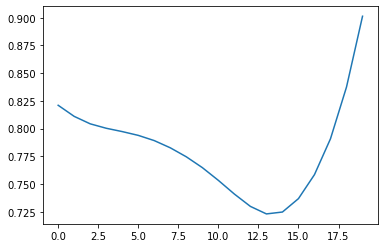

In [197]:
plt.plot(allgoods[3])

In [200]:
# inf_1s = [5+i for i in range(20)]
# inf_2s = [40+i for i in range(20)]
# inf_3s = [80+i for i in range(20)]
# inf_4s = [115+i for i in range(20)]
# bestguess = [10,45,85,130]

# inf_1s = [15+i for i in range(20)]
# inf_2s = [50+i for i in range(20)]
# inf_3s = [90+i for i in range(20)]
# inf_4s = [115+i for i in range(20)]
# bestguess = [24,59,96,128]

inf_1s = [5+i for i in range(20)]
inf_2s = [60+i for i in range(20)]
inf_3s = [85+i for i in range(20)]
inf_4s = [115+i for i in range(20)]
bestguess = [15,69,93,129]

allgoods = []
x = [i for i in range(1,len(wa_totals))]
y = ma
all_infs = [inf_1s,inf_2s,inf_3s,inf_4s]


for k in range(4):
    goodness = []
    for item in all_infs[k]:
        
        inflection_points = bestguess
        inflection_points[k] = item

        popt, pcov = curve_fit(func, x, y,bounds = (0.1,3))

        goodness.append(sum(np.sqrt(np.diag(pcov))))

        print(item)
    allgoods.append(goodness)
        
    print('Best guess for inflection ' + str(k+1) + ' is ' + str(all_infs[k][0]+ goodness.index(min(goodness))))

5
6
7
8
9
10


KeyboardInterrupt: 